# Решение задачи:

## Настройка датасета:

Выполним скачивание необходимого датасета через метод `!wget`:

In [ ]:
# Скачиваем файл
!wget -O Mall_Customers.csv "https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv"

--2025-11-06 20:03:07--  https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/csv]
Saving to: ‘Mall_Customers.csv’

Mall_Customers.csv  100%[===================>]   3.89K  --.-KB/s    in 0s      

2025-11-06 20:03:08 (1.28 GB/s) - ‘Mall_Customers.csv’ saved [3981/3981]



Импортируем необходимых библиотек и отключим предупреждения и ошибки в коде:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA # Визуализация кластеров (пример в 2D через PCA)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Отключает большинство предупреждений

tf.get_logger().setLevel('ERROR')  # Дополнительное отключение логов

import warnings
warnings.filterwarnings('ignore')

Выполним просмотр датасета на 5 первых записях для того, чтобы изучить данные:

In [ ]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Для более детального изучения структуры датасета выполним следующий код:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Далее нам предстоит выполнить предварительную обработку датасета перед основной работой с ним. Выполним удаление дубликатов, проверим, есть ли пропущенные значения, удалим ненужный столбец, осуществим кодирование категориального признака и переименуем колонки:

In [ ]:
# Удаляем полностью дублирующие строки
df = df.drop_duplicates()
print("После удаления дубликатов:", df.shape)

# Проверка на пропущенные значения
print("\nПропущенные значения:")
print(df.isnull().sum())

# Убедимся, что CustomerID не влияет на кластеризацию — удалим его
if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])

# Кодируем категориальный признак 'Genre' (Male/Female → 0/1)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Переименуем колонки для удобства (убираем пробелы и скобки)
df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True).str.rstrip('_')

# Убедимся, что все признаки числовые
print("\nТипы данных:")
print(df.dtypes)

После удаления дубликатов: (200, 5)

Пропущенные значения:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Типы данных:
Gender                   int64
Age                      int64
Annual_Income__k         int64
Spending_Score__1_100    int64
dtype: object


Реализуем нормализацию данных с помощью `StandartScaler()`:

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

### Традиционный метод кластеризации:

После настройки датасета перейдем к традиционному методу кластеризации. Для начала воспользуемся методом локтя и визуализируем его:

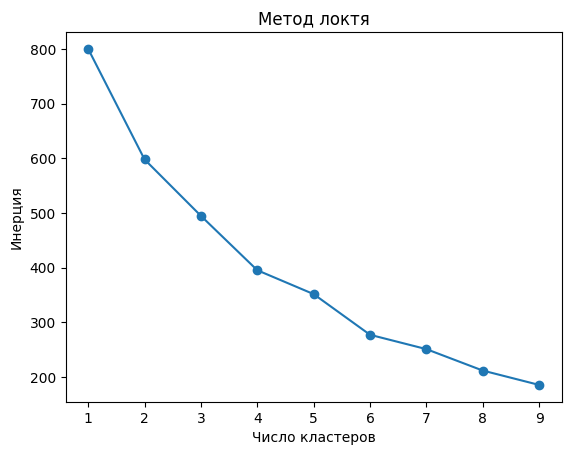

In [ ]:
# Метод локтя
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.show()

Теперь напишем код для использования `Silhouette Score`. Затем так же визуализируем его:

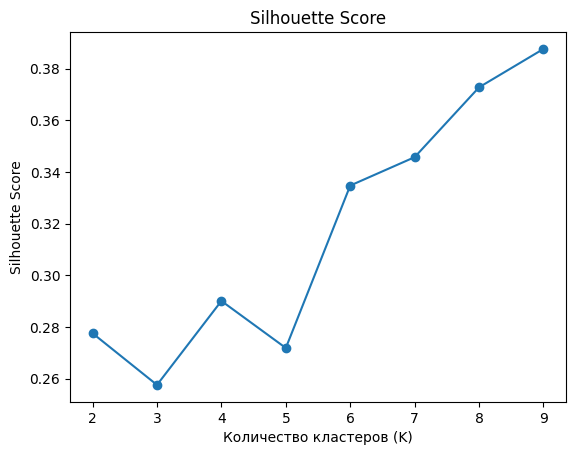

In [ ]:
# Список для хранения Silhouette Scores для каждого K
silhouette_scores = []

# Пробуем разные значения K
for k in range(2, 10):  # Silhouette Score требует как минимум 2 кластера
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

# Построение графика
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

Финальным методом определения количества кластеров будет `Gap Statistic`. Аналогичным образом визуализируем его результаты работы:

**Инерция (inertia)** - это мера качества кластеризации, которая показывает, насколько "компактно" расположены точки внутри кластеров.

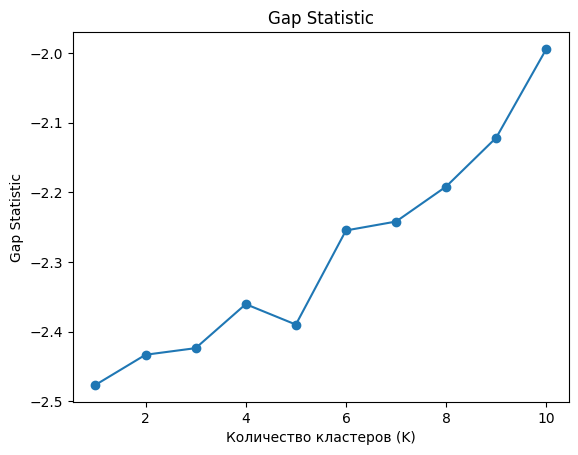

In [ ]:
def compute_gap_statistic(df, max_k=10, n_refs=20):
    gaps = []  # Будем хранить значения Gap statistic для каждого k
    sses = []  # Будем хранить значения инерции (сумма квадратов расстояний) для каждого k

    # Перебираем возможное количество кластеров от 1 до max_k
    for k in range(1, max_k + 1):
        # Кластеризуем исходные данные
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        sse = kmeans.inertia_  # Инерция - мера компактности кластеров
        sses.append(sse)

        # Создаем случайные данные (без реальной кластерной структуры)
        ref_sses = []
        for _ in range(n_refs):
            ref_data = np.random.rand(*df.shape)  # Случайные данные того же размера
            ref_kmeans = KMeans(n_clusters=k)
            ref_kmeans.fit(ref_data)
            ref_sses.append(ref_kmeans.inertia_)  # Инерция для случайных данных

        # Вычисляем Gap statistic: разница между логарифмами инерции случайных и реальных данных
        gap = np.log(np.mean(ref_sses)) - np.log(sse)
        gaps.append(gap)

    return gaps, sses

# Вычисляем Gap statistic для наших данных
gaps, sses = compute_gap_statistic(df_scaled)

# Построение графика Gap Statistic
plt.plot(range(1, 11), gaps, marker='o')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic')
plt.show()

На основе реализации последних трех методов выбор был сделан в пользу 4 кластеров. Применим это в финальной части кластеризации:

Для этого воспользуемся функцией `KMeans()` и визуализируем результат. Для визуализации будем использовать `PCA`, он превращает сложные многомерные данные в простую двумерную картинку, сохраняя максимально возможную информацию о структуре данных. Также выведем дисперсию, которая в процентном соотношении указывает на количество данных, участвовавших в формировании графика:

Объясненная дисперсия: [0.33690046 0.26230645]


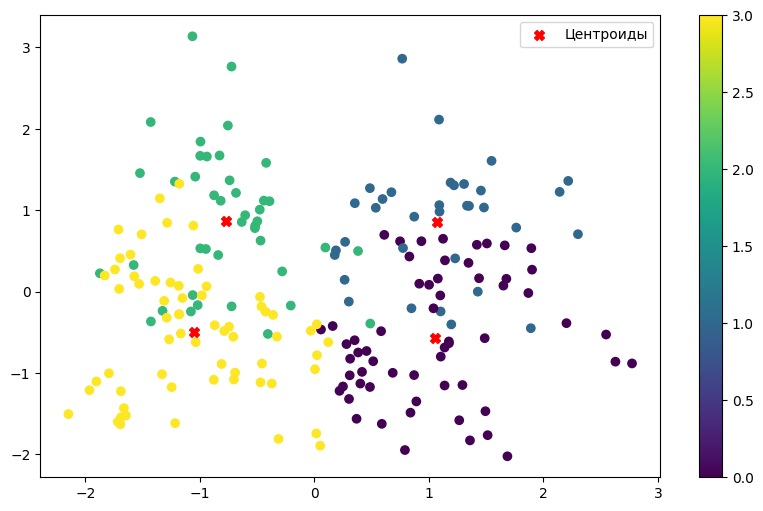

In [ ]:
# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Визуализация с центроидами и объясненной дисперсией
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap='viridis')
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='X', label='Центроиды')
plt.colorbar(scatter)
plt.legend()
plt.show()

### Кластеризация с автокодировщиком:

Перейдем к кластеризации с глубоким обучением, в основе которого будет лежать автокодировщик с самой простой архитектурой, в которой будем использовать только полносвязные слои - **Dense**.

Следующий код задаёт размерность входных данных и скрытого представления для автоэнкодера, определяя архитектуру нейросети:

In [ ]:
# Создание автоэнкодера
input_dim = df_scaled.shape[1]
encoding_dim = 2

Опишем энкодер и декодер, соберем модель и выполним ее компиляцию:

In [ ]:
# Энкодер
input_layer = Input(shape=(input_dim,))
encoder = Dense(100, activation='relu')(input_layer)
encoder = Dense(50, activation='relu')(encoder)
bottleneck = Dense(encoding_dim, activation='relu')(encoder)

# Декодер
decoder = Dense(50, activation='relu')(bottleneck)
decoder = Dense(100, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Выполним обучение нашей модели:

In [ ]:
history = autoencoder.fit(df_scaled, df_scaled,
                         epochs=300,
                         batch_size=16,
                         shuffle=True,
                         verbose=0,
                         callbacks=[EarlyStopping(patience=15, restore_best_weights=True)])

Этот код создаёт упрощённую модель-энкодер для преобразования исходных данных в сжатые скрытые представления и выполняет это преобразование для всего датасета.

Скрытые представления нужны для сжатия исходных данных в более низкоразмерное пространство, где скрытые закономерности и структуры данных становятся более явными для последующей кластеризации.

In [ ]:
# Создание модели энкодера для получения скрытых представлений
encoder_model = Model(inputs=input_layer, outputs=bottleneck)

# Получение скрытых представлений
encoded_data = encoder_model.predict(df_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Далее выполним кластеризацию **K-means** на сжатых данных, полученных от автоэнкодера, и добавим метки кластеров в исходный датафрейм:

In [ ]:
# Кластеризация на скрытых представлениях с помощью K-means
kmeans_ae = KMeans(n_clusters=4, random_state=42)
df['Cluster_AE'] = kmeans_ae.fit_predict(encoded_data)

Выполним визуализацию результатов:

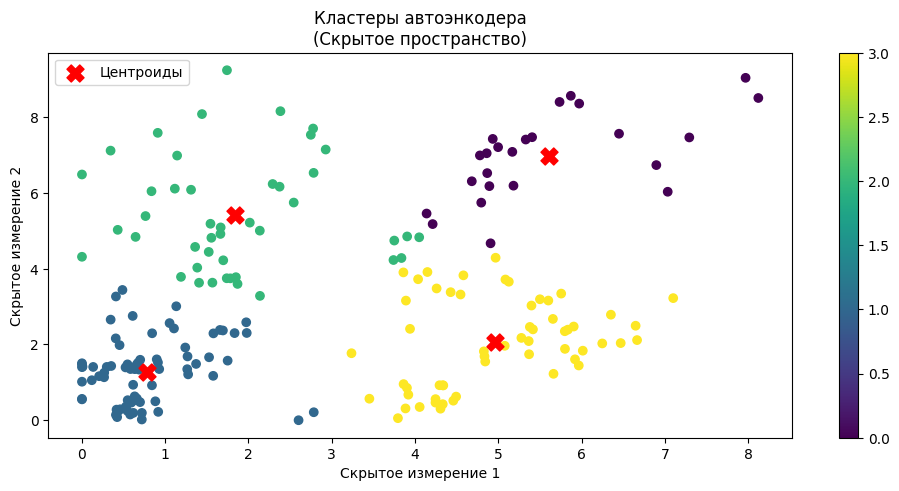

In [ ]:
# Визуализация кластеров автоэнкодера
plt.figure(figsize=(12, 5))

# Визуализация в пространстве скрытых представлений
scatter1 = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=df['Cluster_AE'], cmap='viridis')
centers_ae = kmeans_ae.cluster_centers_
plt.scatter(centers_ae[:, 0], centers_ae[:, 1], c='red', s=150, marker='X', label='Центроиды')
plt.colorbar(scatter1)
plt.xlabel('Скрытое измерение 1')
plt.ylabel('Скрытое измерение 2')
plt.title('Кластеры автоэнкодера\n(Скрытое пространство)')
plt.legend()
plt.show()

## Вывод:

Финальный код вычисляет и сравнивает метрики качества кластеризации для методов на основе автоэнкодера и обычного K-means, показывая, какой подход лучше разделяет данные на группы:

In [ ]:
# Оценка качества кластеризации автоэнкодера
ae_silhouette = silhouette_score(encoded_data, df['Cluster_AE'])
print(f"Silhouette Score (Autoencoder): {ae_silhouette:.3f}")

# Сравнение с обычным K-means
kmeans_silhouette = silhouette_score(df_scaled, df['Cluster'])
print(f"Silhouette Score (K-means): {kmeans_silhouette:.3f}")

Silhouette Score (Autoencoder): 0.537
Silhouette Score (K-means): 0.290


На основании проведённых сравнений и анализа графиков можно сделать вывод, что метод кластеризации с использованием глубокого обучения продемонстрировал значительно лучшие результаты, даже при применении простейшего автокодировщика. Оптимизация параметров и более детальная настройка алгоритма позволили бы улучшить эти результаты ещё больше. Традиционный метод также показал достойные результаты, однако разница в сравнении с методом глубокого обучения становится очевидной.